This Jupyter Notebook is make by Andres Moreno , email: clases.ya10@gmail.com to Hierarqcal, led by Matt Lawrence. 



The next work is focus on calculating the electronic ground state energy for the hydrogen ($\text{H}_{2}$)

The next code only work in linux system, for the installation of the "pip install pyscf" necessary to extract some data for the molecule.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature import settings
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.primitives import Sampler
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP, SPSA, QNSPSA
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.circuit.library import TwoLocal
from functools import partial as apply_variation
from pyscf import gto, scf
import pyqmc.api as pyq
import h5py
from ase import Atoms
from ase.build import molecule
from ase.visualize import view
import scipy.stats as stats
import time, datetime
import pandas as pd
import os.path
from qiskit.circuit import Parameter
from typing import List, NamedTuple


from hierarqcal import (
    Qhierarchy,
    Qcycle,
    Qpermute,
    Qmask,
    Qunmask,
    Qinit,
    Qmotif,
    Qmotifs,
    plot_motif,
    Qunitary,
)


## 1.Description of the VQE algorithm
In a loop, a classical computer optimizes the parameters of a quantum circuit with respect to an objective function, such as finding the ground state of a molecule, which is the state with the lowest energy. The parameterized quantum circuit prepares a trial quantum state as a trial solution (an ansatz). By repeatedly measuring qubits at the output of the quantum circuit, we get the expectation value of the energy observable with respect to the trial state.


The VQE algorithm provides an estimate of the ground state of a given quantum system encoded as a Hamiltonian $\hat{H}$, the state of the system with the lowest energy $E_0$, for instance the ground state energy of a molecule. It involves an iterative minimization of the expectation value $E_{\Psi(\theta)}$ of the energy observable with respect to the trial state $|\Psi(\theta)\rangle$:
$$
E_0 \leq E_{\Psi(\theta)}=\langle\Psi(\theta)|H|\Psi(\theta)\rangle
$$

Pauli matrices, we can decompose the Hamiltonian $\hat{H}$ into the weighted sum of $M$ tensor products $P_{k}=\otimes_{j}^{N} \sigma_{i, j}$ where $\sigma_{i,j}∈\{1,\sigma_X,\sigma_Y,\sigma_Z\}$ with weights $c_k$ and $N$ qubits:

$$
H=\sum_{k=0}^{M-1} c_k P_k = \sum_{k=0}^{M-1}c_k \otimes_j^N σ_{k,j}
$$

Hence the expectation value of the energy observable $E_{\Psi(\theta)}$ can be rewritten as follows:

$$E_{\psi(\theta)}=\langle\Psi(\theta)|\hat{H}| \Psi(\theta)\rangle=\sum_{k=0}^{M-1} c_{k}\left\langle\Psi(\theta)\left|P_{k}\right| \Psi(\theta)\right\rangle=\sum_{k=0}^{M-1} c_{k}\left\langle\Psi(\theta)\left|\otimes_{j}^{N} \sigma_{k, j}\right| \Psi(\theta)\right\rangle$$

We prepare a trial state $\Psi(\theta)$ with the set of parameters $\theta=\left(\theta_{0}, \theta_{1}, \ldots, \theta_{m}\right)$ with a quantum circuit initialized in the state $|0\rangle^{\otimes N}$, and represented by $U(\theta)$ which outputs the state $|\Psi(\theta)\rangle=U(\theta)|0\rangle^{\otimes N}$. 

By transpose complex conjugating,  $\langle\Psi|=\left\langle 0\right|^{\otimes N} U(\theta)^{\dagger}$, we can rewrite the expectation value of the energy observable $E_{\Psi(\theta)}$ as follows:

$$E_{\Psi(\theta)}=\left\langle 0\right|^{\otimes N} U(\theta)^{\dagger} \hat{H} U(\theta)|0\rangle^{\otimes N}$$

and then by taking the sum out to the front:

$$E_{\Psi(\theta)}=\sum_{k=0}^{M-1}\left\langle\Psi(\theta)\left|P_{k}\right| \Psi(\theta)\right\rangle=\sum_{k=0}^{M-1} c_{k}\left\langle 0\right|^{\otimes N} U(\theta)^{\dagger} \otimes_{j}^{N} \sigma_{k, j} U(\theta)|0\rangle^{\otimes N}$$

For each $P_k$, we run the quantum circuit $U(\theta)$ followed by rotations $R_{k} \in\left\{\mathbb{1}, R_{X}(-\pi / 2), R_{Y}(\pi / 2)\right\}$ depending on $P_k$ before measuring the qubits in the $Z$ basis so that we effectively measure the output state in the basis of the eigenvectors of $P_k$ to get the expectation value $\left\langle\Psi(\theta)\left|P_{k}\right| \Psi(\theta)\right\rangle$ with respect to the output state $|\Psi(\theta)\rangle=U(\theta)|0\rangle^{\otimes N}$.

On a classical computer, we compute the weighted sum of the expectation values $\left\langle\Psi(\theta)\left|P_{k}\right| \Psi(\theta)\right\rangle$ with weights $c_k$ to get the expectation value $E_{\Psi(\theta)}$ with respect to the output state $\Psi(\theta)$.

We update the set of parameters $θ$ using a classical optimization routine minimizing the expectation value $E_{\Psi(\theta)}$ until convergence in the value of the energy or the maximum allowable number of iterations is reached.

The parameters at convergence define approximately the ground state $|\Psi(\theta_{min})\rangle$ of a quantum system encoded into a Hamiltonian $H$ with the lowest energy $E_{\min }=\left\langle\Psi\left(\theta_{\min }\right)|H| \Psi\left(\theta_{\min }\right)\right\rangle$.



###  Trial wavefunctions

The coupled-cluster (CC) theory constructs a multi-electron wavefunction (Ψ) using the exponential cluster operator $\widehat{T}=\widehat{T}_{1}+\widehat{T}_{2}+\cdots \widehat{T}_{n}$, where $\widehat{T}_{1}$ is the operator for all single excitations, $\widehat{T}_{1}$ is the operator for all double excitations, and so on. We start the VQE with the following unitary coupled cluster (UCC) ansatz of the quantum state $|\Psi(\theta)\rangle$ with variational parameter $θ$ [Panagiotis] [Lolur]:

$$|\Psi(\theta)\rangle=e^{\widehat{T}(\theta)-\widehat{T}^{\dagger}(\theta)}\left|\Psi_{r e f}\right\rangle$$

where $\left|\Psi_{\text {ref }}\right\rangle$ is the Hartree-Fock ground state. In the UCC method restricted to the extension to single and double excitations (UCCSD), the operators $\widehat{T}_{1}$ and $\widehat{T}_{2}$ can be expanded as follows:

$$\widehat{T}_{1}(\theta)=\sum_{i ; m} \theta_{i}^{m} a_{m}^{\dagger} a_{i}$$

$$\widehat{T}_{2}(\theta)=\frac{1}{2} \sum_{i, j ; m, n} \theta_{i, j}^{m, n} a_{n}^{\dagger} a_{m}^{\dagger} a_{j} a_{i}$$

where:
- $a_m^†$ is the fermionic creation operator , Fermion creation operator
- $a_i$ is the fermionic annihilation operator , Fermion annihilation operator
- $θ$ is the set of parameters for all expansion coefficients.

The UCCSD ansatz of the quantum state $|\Psi(\theta)⟩$ is then mapped to qubit operators with the Jordan-Wigner (JW), the Parity or the Bravyi-Kitaev (BK) . Fermion to qubit mappings resulting in an initial qubit state vector for the VQE calculation.

## 2.Setting-up the functions for the calculation
We set a heuristic ansatz, using hierarqcal.

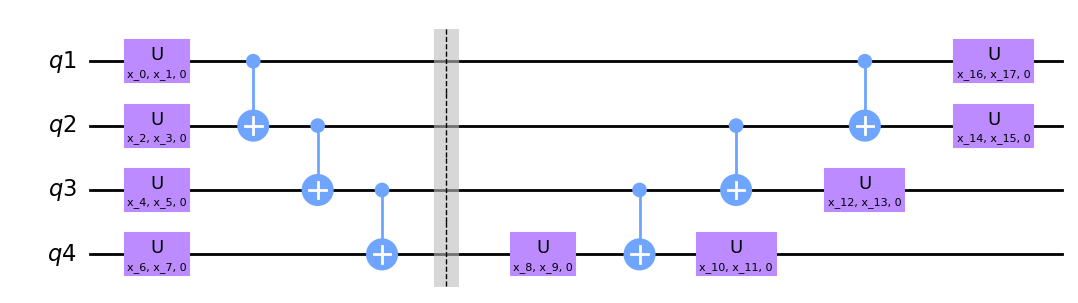

In [2]:
def U(bits, symbols=None, circuit=None, **kwargs):
    # Assume bits are strings and in the correct QASM format
    q0, q1, q2, q3 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1]), QuantumRegister(1, bits[2]), QuantumRegister(1, bits[3])

    circuit.u(symbols[0],symbols[1],0,q0)
    circuit.u(symbols[2],symbols[3],0,q1)
    circuit.u(symbols[4],symbols[5],0,q2)
    circuit.u(symbols[6],symbols[7],0,q3)
    circuit.cnot(q0, q1)
    circuit.cnot(q1, q2)
    circuit.cnot(q2, q3)
    return circuit


def U2(bits, symbols=None, circuit=None, **kwargs):
    # Assume bits are strings and in the correct QASM format
    q0, q1, q2, q3 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1]), QuantumRegister(1, bits[2]), QuantumRegister(1, bits[3])

    circuit.u(symbols[0],symbols[1],0,q3)
    circuit.cnot(q2, q3)
    circuit.cnot(q1, q2)
    circuit.cnot(q0, q1)
    circuit.u(symbols[2],symbols[3],0,q3)
    circuit.u(symbols[4],symbols[5],0,q2)
    circuit.u(symbols[6],symbols[7],0,q1)
    circuit.u(symbols[8],symbols[9],0,q0)
    return circuit


u=Qunitary(U, arity=4, n_symbols=8)
u2=Qunitary(U2, arity=4, n_symbols=10)
hierq = Qinit(4) +Qcycle(1, 1, 0, mapping=u, boundary="open")+ Qcycle(1, 1, 0, mapping=u2, boundary="open")
tl_circuit = hierq(backend="qiskit")
tl_circuit.draw("mpl") 

We use the fermion_to_qubit() function to constructing a qubit Hamiltonian with Qiskit Nature to convert a fermionic operator to a qubit operator. 

In [3]:
def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
  if show:
    print("Qubit Hamiltonian operator")
    print("{} transformation ". format(mapper_name))
  match mapper_name:
    case "Jordan-Wigner":
      mapper = JordanWignerMapper()
    case "Parity":
      mapper = ParityMapper(num_particles=problem.num_particles)
    case "Bravyi-Kitaev":
      mapper = BravyiKitaevMapper()
  qubit_op = mapper.map(second_q_op)
  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)
  n_items = len(qubit_op)
  if show:
    print("Number of items in the Pauli list:", n_items)
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])
  return qubit_op, mapper

We use the get_particle_number() function, Constructing a fermionic Hamiltonian operator of the hydrogen molecule, which gets the particle number property of a given electronic structure problem .

In [4]:
def get_particle_number(problem, show=True):
  num_spin_orbitals = problem.num_spin_orbitals
  num_particles = problem.num_particles
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
  return num_particles, num_spin_orbitals

Qiskit Nature provides a class called GroundStateEigensolver to calculate the ground state of a molecule. We define the run_vqe() function for these process.

In [5]:
def run_vqe(name, problem, qubit_converter, solver, show=True):
  calc = GroundStateEigensolver(qubit_converter, solver)
  start = time.time()
  ground_state = calc.solve(problem)
  elapsed = str(datetime.timedelta(seconds = time.time()-start))
  if show:
    print("Running the VQE using the {}".format(name))
    print("Elapsed time: {} \n".format(elapsed))
    print(ground_state)
  return ground_state

We define the plot_loss() function

In [6]:
def plot_loss(loss, label, target,problem):
  plt.figure(figsize=(12, 6))
  plt.plot(loss, 'tab:green', ls='--', label=label)
  plt.axhline(target, c='tab:red', ls='--', label='target')
  plt.ylabel('loss (hartree)')
  plt.xlabel('iterations')
  plt.legend()

We now define the solve_ground_state() function, which solves for a ground state.

In [7]:
def solve_ground_state(
    info_dict,
    mapper_name="Jordan-Wigner",
    num_electrons=None,
    num_spatial_orbitals=None,
    freeze_core=None, 
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):
    
    atoms = info_dict['atoms']
    coords = info_dict['coords']
    charge = info_dict['charge']
    multiplicity = info_dict['multiplicity']
    atom_pair = info_dict['atom_pair']
    moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
    driver = PySCFDriver.from_molecule(moleculeinfo, basis="sto3g")
    problem = driver.run()
    fermionic_hamiltonian = problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
  
    if show:
      print("Fermionic Hamiltonian operator")
      print("\n".join(str(second_q_op).splitlines()[:20] + ["..."]))
    num_particles, num_spin_orbitals = get_particle_number(problem, show=show)
    if show:
      print(" ")
    qubit_op, mapper = fermion_to_qubit(problem, second_q_op, mapper_name, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, show=show)
    
    if show:
      print(" ")
    
    ground_state = run_vqe(name_solver, problem, mapper, solver, show=show)

    plot_loss(loss, label, target,problem)  
    return fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, mapper, ground_state 

## 3. Setting-up hydrogen molecule

We define the molecular geometry of the hydrogen molecule as follows:

In [8]:
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair=(1, 0)
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity, 'atom_pair':H2_atom_pair}

We set up the VQE using a heuristic ansatz.

In [9]:
estimator = Estimator()
optimizer = SPSA(maxiter=200)
vqe_tl_solver = VQE(estimator, tl_circuit, optimizer)


We set up a call back function qnspsa_callback() for the Quantum Natural SPSA (QN-SPSA) optimizer which appends results to the loss array qnspsa_loss.

In [10]:
qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

Here is the code which sets up the VQE using a heuristic ansatz and the Quantum Natural SPSA (QN-SPSA) optimizer:

In [11]:

ansatz = tl_circuit
fidelity = QNSPSA.get_fidelity(ansatz, sampler=Sampler())
qnspsa = QNSPSA(fidelity, maxiter=400, learning_rate=0.01, perturbation=0.3, callback=qnspsa_callback)
vqe_tl_QNSPSA_solver = VQE(estimator, tl_circuit, optimizer=qnspsa)

Now we call solve_ground_state() with the heuristic ansatz and the QN-SPSA optimizer. Figure shows the plot of the loss function of the QN-SPSA optimizer. The hamiltonian of the molecule is mapped to qubit operator with the Jordan-Wigner. The electronic ground state reported in literature is -1.857274810366 Hartree.

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
...
Number of particles: (1, 1)
Number of spin orbitals: 4
 
Qubit Hamiltonian operator
Jordan-Wigner transformation 
Number of items in the Pauli list: 15

/home/veroni/.local/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


Running the VQE using the Two-Local circuit and the QN-SPSA optimizer
Elapsed time: 0:00:36.394382 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.836797561017
  - computed part:      -1.836797561017
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.116828566568
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.390457253003]
    - computed part:      [0.0  0.0  1.390457253003]
  > Dipole moment (a.u.): [0.0  0.0  -0.001508553003]  Total: 0.001508553003
                 (debye): [0.0  0.0  -0.003834358909]  Total: 0.003834358909
 


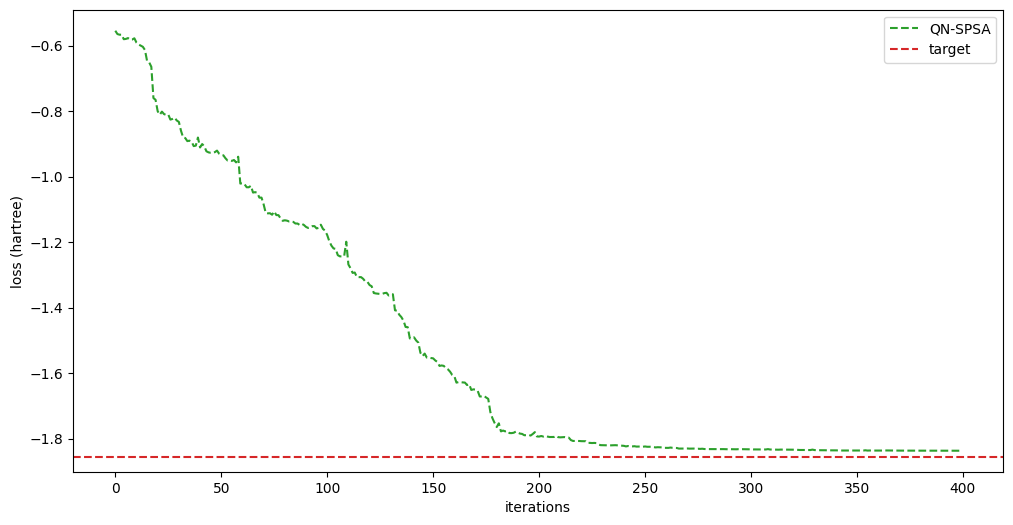

In [12]:
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(H2_info_dict, mapper_name="Jordan-Wigner", two_qubit_reduction=True, z2symmetry_reduction=None,
                  loss=qnspsa_loss, label='QN-SPSA', target=-1.857274810366,
                  name_solver='Two-Local circuit and the QN-SPSA optimizer', solver=vqe_tl_QNSPSA_solver )